In [60]:
import argparse
import geopandas as gpd
import logging
import numpy as np
import os
import os.path as osp
import pandas as pd
import warnings
from pyproj import Geod
from matplotlib import pyplot as plt
import sys 
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from utils.geometric_utils import read_vector_data, create_logger, get_nearest_poly , prep_polygons_asarr
from utils.haversine_distance import get_distance

In [2]:
geod = Geod(ellps="WGS84")
warnings.filterwarnings("ignore")

from os.path import isfile

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Texas"
city = "Bexar"
parcel_dir = "Parcels_48029"
apt_data_path = os.path.join(data_path,state,"APT_2022_09_000_nam_usa_utx.shp" )
parcel_path = os.path.join(data_path,state,city,"{}/{}.shp".format(parcel_dir,parcel_dir))
building_geojson = os.path.join(data_path,state,'{}.shp'.format(state))

print("APT data path",apt_data_path)
print("Parcel Data ",parcel_path)
print("Building_geojson",building_geojson)



APT data path /mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/Texas/APT_2022_09_000_nam_usa_utx.shp
Parcel Data  /mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/Texas/Bexar/Parcels_48029/Parcels_48029.shp
Building_geojson /mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/Texas/Texas.shp


In [7]:
def get_bfp_parcel_overlap(land_parcels,building_footprints):
    
    print("Reading Land Parcel data .. ")
    land_parcel_df = read_vector_data(land_parcels)
    print("Reading Building Footprints ..  ")
    footprint_df = read_vector_data(building_footprints)
    
    print("creating sjoin of land Parcel data and Building Footprints.. ")
    building_within_parcel_df = gpd.sjoin(land_parcel_df, footprint_df, op='intersects', how='left')
    building_within_parcel_df = building_within_parcel_df.dropna()  # drop columns with no Buildings

    def __get_buildingfootprint(val):
        return footprint_df['geometry'].loc[val]

    def __get_building_roi(data: gpd.GeoSeries):
        building_polygon = data['building_geometry']
        parcel_polygon = data['geometry']
        building_roi = None
        try:
            if building_polygon == np.nan:
                building_roi = parcel_polygon
            if building_polygon.area > parcel_polygon.area:
                building_roi = parcel_polygon.intersection(building_polygon)
            else:
                building_roi = building_polygon
        except:
            logging.error("error for {},{}".format(building_polygon, parcel_polygon))
        return building_roi

    building_within_parcel_df['building_geometry'] = building_within_parcel_df['index_right'].apply(lambda x: __get_buildingfootprint(x))

    building_within_parcel_df['building_roi'] = building_within_parcel_df.apply(lambda x: __get_building_roi(x), axis=1)
    building_within_parcel_df = building_within_parcel_df.drop(['index_right', 'release'],axis=1)
    building_within_parcel_df = building_within_parcel_df.dropna()
    return building_within_parcel_df

### Process Land Parcels and Building footprints 
This code read the parcel and building footprint data and finds out sjoin of both geometries .
It rejects the data where building footprints is not found .

In [8]:
parcel_bfp_df = get_bfp_parcel_overlap(land_parcels=parcel_path,building_footprints=building_geojson)

Reading Land Parcel data .. 
Reading Building Footprints ..  
creating sjoin of land Parcel data and Building Footprints.. 


In [9]:
parcel_bfp_df.head(4)

,APN,FIPS,PRCLDMPID,geometry,index_right,release,capture_da,building_geometry,building_roi
0,04708-400-8120,48029,100660192_179591036,"POLYGON ((-98.64792 29.74550, -98.64799 29.745...",8476766.0,2.0,1/11/2020-1/12/2020,"POLYGON ((-98.64756199999999 29.7457, -98.6476...","POLYGON ((-98.64756 29.74570, -98.64761 29.745..."
1,04708-400-8130,48029,100660192_179591037,"POLYGON ((-98.64784 29.74521, -98.64785 29.745...",10207205.0,2.0,1/11/2020-1/12/2020,"POLYGON ((-98.647758 29.745252, -98.647762 29....","POLYGON ((-98.64776 29.74525, -98.64776 29.745..."
3,04708-400-8620,48029,100660192_179591018,"POLYGON ((-98.65098 29.74624, -98.65102 29.746...",6678599.0,2.0,1/11/2020-1/12/2020,"POLYGON ((-98.65074799999999 29.74648, -98.650...","POLYGON ((-98.65075 29.74648, -98.65069 29.746..."
4,04708-400-8360,48029,100660192_179591017,"POLYGON ((-98.65151 29.74581, -98.65177 29.746...",619716.0,2.0,1/11/2020-1/12/2020,"POLYGON ((-98.651231 29.746064, -98.651323 29....","POLYGON ((-98.65123 29.74606, -98.65132 29.746..."


### Get BFP's within Parcel
The code performs a groupby to evaluate how many buildings are there within a Parcel and creates a filter dataframe for it .

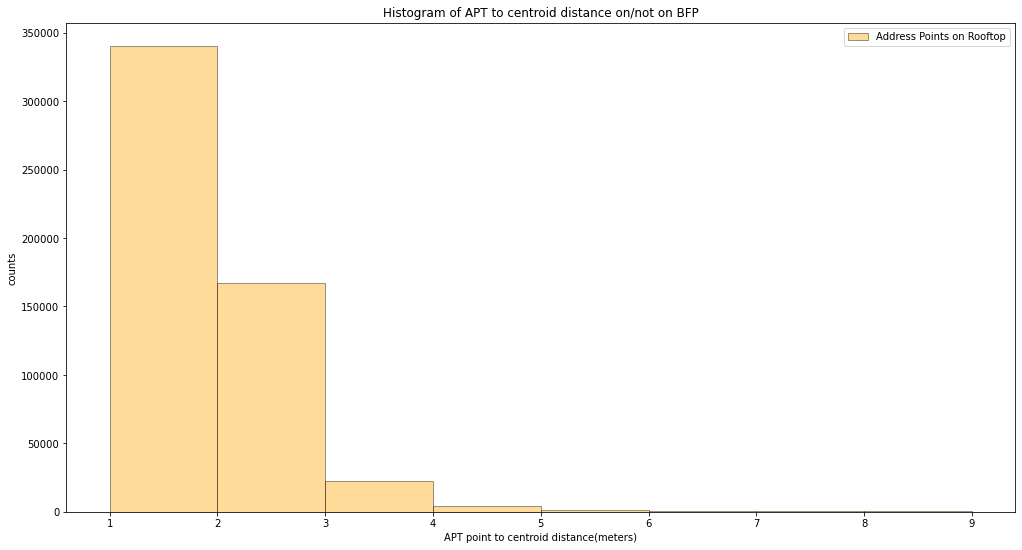

In [17]:
building_within_parcel_count = parcel_bfp_df.groupby('PRCLDMPID')['geometry'].count()
# building_within_parcel_count.hist(bins=np.arange(0,10,1))

fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(building_within_parcel_count, bins = np.arange(1,10,1))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()

In [33]:
def get_buildings_within_parcel(data: gpd.GeoSeries, count=None):
    print("Acquiring BFP's within land Parcels ".format(count))
    building_within_parcel_count = data.groupby('PRCLDMPID')['geometry'].count()
    if count == 1:
        parcel_ids_with_one_building = list(building_within_parcel_count[building_within_parcel_count == 1].keys())
        filtered_dataframe = data[data['PRCLDMPID'].isin(parcel_ids_with_one_building)]
    elif count == 2:
        parcel_ids_with_two_buildings = list(building_within_parcel_count[building_within_parcel_count == 2].keys())
        filtered_dataframe = data[data['PRCLDMPID'].isin(parcel_ids_with_two_buildings)]
    else:
        parcel_ids_with_n_buildings = list(building_within_parcel_count[building_within_parcel_count > 2].keys())
        filtered_dataframe = data[data['PRCLDMPID'].isin(parcel_ids_with_n_buildings)]
    return filtered_dataframe

df_parcel_within_bfp = get_buildings_within_parcel(parcel_bfp_df, count=2)

Acquiring BFP's within land Parcels 


In [34]:
print("Data shape",df_parcel_within_bfp.shape)
df_parcel_within_bfp.head(6)

Data shape (333632, 9)


,APN,FIPS,PRCLDMPID,geometry,index_right,release,capture_da,building_geometry,building_roi
5,04708-400-8540,48029,100660192_179591016,"POLYGON ((-98.64905 29.74629, -98.64946 29.746...",6349640.0,2.0,1/11/2020-1/12/2020,"POLYGON ((-98.649269 29.746693, -98.6490529999...","POLYGON ((-98.64927 29.74669, -98.64905 29.746..."
5,04708-400-8540,48029,100660192_179591016,"POLYGON ((-98.64905 29.74629, -98.64946 29.746...",9886908.0,2.0,1/11/2020-1/12/2020,"POLYGON ((-98.64890800000001 29.746815, -98.64...","POLYGON ((-98.64891 29.74682, -98.64906 29.746..."
7,04708-400-8580,48029,100660192_179591014,"POLYGON ((-98.65036 29.74637, -98.65051 29.746...",5345654.0,2.0,1/11/2020-1/12/2020,"POLYGON ((-98.65002 29.746388, -98.650018 29.7...","POLYGON ((-98.65002 29.74639, -98.65002 29.746..."
7,04708-400-8580,48029,100660192_179591014,"POLYGON ((-98.65036 29.74637, -98.65051 29.746...",8881196.0,2.0,1/11/2020-1/12/2020,"POLYGON ((-98.650238 29.746478, -98.650256 29....","POLYGON ((-98.65024 29.74648, -98.65026 29.746..."
16,04708-400-8530,48029,100660192_179591028,"POLYGON ((-98.64860 29.74652, -98.64924 29.746...",9886908.0,2.0,1/11/2020-1/12/2020,"POLYGON ((-98.64890800000001 29.746815, -98.64...","POLYGON ((-98.64891 29.74682, -98.64906 29.746..."
16,04708-400-8530,48029,100660192_179591028,"POLYGON ((-98.64860 29.74652, -98.64924 29.746...",5634281.0,2.0,1/11/2020-1/12/2020,"POLYGON ((-98.64891900000001 29.747164, -98.64...","POLYGON ((-98.64892 29.74716, -98.64892 29.747..."


In [35]:
df_parcel_within_bfp = df_parcel_within_bfp.drop(['index_right','release'],axis=1)

### Read the Ancor point data 

In [36]:
def get_parcel_anchorpoints(anchor_points_data,input_dataframe: gpd.GeoSeries):
    print("Reading Anchor-Points data over Parcel-Building Geo-Dataframe")
    
    anchorpoint_df = read_vector_data(anchor_points_data)
    apt_df_columns = list(anchorpoint_df.columns)
    
    print("Processing Anchor-Points and Parcel-Building Geo-Dataframe")
    # find spatial join of input_dataframe with anchorpoint
    grouped_df = gpd.sjoin(input_dataframe, anchorpoint_df, op='contains', how='inner')
    print(grouped_df.keys())

    def _get_apt_point(val):
        return anchorpoint_df['geometry'].loc[val]

    grouped_df['APT'] = grouped_df['index_right'].apply(lambda x: _get_apt_point(x))
    grouped_df = grouped_df.drop(['index_right'], axis=1)
    return grouped_df , apt_df_columns

process_df , cols = get_parcel_anchorpoints(apt_data_path,df_parcel_within_bfp)


Reading Anchor-Points data over Parcel-Building Geo-Dataframe
Processing Anchor-Points and Parcel-Building Geo-Dataframe
Index(['APN', 'FIPS', 'PRCLDMPID', 'geometry', 'capture_da',
       'building_geometry', 'building_roi', 'index_right', 'feat_id',
       'iso_script', 'iso_lang_c', 'postal_cod', 'house_numb', 'state_prov',
       'locality', 'street_nam', 'country_co', 'prefix', 'suffix', 'predir',
       'postdir', 'sn_body'],
      dtype='object')


In [38]:
print("Required columns",cols)
process_df.head(6)

Required columns ['feat_id', 'iso_script', 'iso_lang_c', 'postal_cod', 'house_numb', 'state_prov', 'locality', 'street_nam', 'country_co', 'prefix', 'suffix', 'predir', 'postdir', 'sn_body', 'geometry']


,APN,FIPS,PRCLDMPID,geometry,capture_da,building_geometry,building_roi,feat_id,iso_script,iso_lang_c,...,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT
5,04708-400-8540,48029,100660192_179591016,"POLYGON ((-98.64905 29.74629, -98.64946 29.746...",1/11/2020-1/12/2020,"POLYGON ((-98.649269 29.746693, -98.6490529999...","POLYGON ((-98.64927 29.74669, -98.64905 29.746...",00005554-3400-2800-0000-000000bdd9d6,Latn,ENG,...,TX,Boerne,Double Eagle Cir,USA,None,Cir,None,None,Double Eagle,POINT (-98.64909280000001 29.7467072)
5,04708-400-8540,48029,100660192_179591016,"POLYGON ((-98.64905 29.74629, -98.64946 29.746...",1/11/2020-1/12/2020,"POLYGON ((-98.64890800000001 29.746815, -98.64...","POLYGON ((-98.64891 29.74682, -98.64906 29.746...",00005554-3400-2800-0000-000000bdd9d6,Latn,ENG,...,TX,Boerne,Double Eagle Cir,USA,None,Cir,None,None,Double Eagle,POINT (-98.64909280000001 29.7467072)
7,04708-400-8580,48029,100660192_179591014,"POLYGON ((-98.65036 29.74637, -98.65051 29.746...",1/11/2020-1/12/2020,"POLYGON ((-98.65002 29.746388, -98.650018 29.7...","POLYGON ((-98.65002 29.74639, -98.65002 29.746...",00005554-3400-2800-0000-000000bdd9c6,Latn,ENG,...,TX,Boerne,Fairway Green Dr,USA,None,Dr,None,None,Fairway Green,POINT (-98.650155 29.7466121)
7,04708-400-8580,48029,100660192_179591014,"POLYGON ((-98.65036 29.74637, -98.65051 29.746...",1/11/2020-1/12/2020,"POLYGON ((-98.650238 29.746478, -98.650256 29....","POLYGON ((-98.65024 29.74648, -98.65026 29.746...",00005554-3400-2800-0000-000000bdd9c6,Latn,ENG,...,TX,Boerne,Fairway Green Dr,USA,None,Dr,None,None,Fairway Green,POINT (-98.650155 29.7466121)
16,04708-400-8530,48029,100660192_179591028,"POLYGON ((-98.64860 29.74652, -98.64924 29.746...",1/11/2020-1/12/2020,"POLYGON ((-98.64890800000001 29.746815, -98.64...","POLYGON ((-98.64891 29.74682, -98.64906 29.746...",00005554-3400-2800-0000-000000bdd9db,Latn,ENG,...,TX,Boerne,Double Eagle Cir,USA,None,Cir,None,None,Double Eagle,POINT (-98.6488985 29.7469491)
16,04708-400-8530,48029,100660192_179591028,"POLYGON ((-98.64860 29.74652, -98.64924 29.746...",1/11/2020-1/12/2020,"POLYGON ((-98.64891900000001 29.747164, -98.64...","POLYGON ((-98.64892 29.74716, -98.64892 29.747...",00005554-3400-2800-0000-000000bdd9db,Latn,ENG,...,TX,Boerne,Double Eagle Cir,USA,None,Cir,None,None,Double Eagle,POINT (-98.6488985 29.7469491)


### Processing starts from here 

In [78]:

def check_point_on_polygon(bfp_polygon, apt_point):
    flag = False
    if bfp_polygon.contains(apt_point):
        flag = True
    return flag

def multi_map(x,required_cols, area_thresh=150,bfp_per_parcel =2 ):
    ret = dict()
    req_columns = ['PRCLDMPID', 'building_roi', 'APT'] + required_cols
    # get two buildings as we have selected 
    
    
    for cols in req_columns:
        ret[cols] = x.iloc[0][cols]
    
    if bfp_per_parcel ==2:
        building_polygons = list(x['building_roi'][:2])
        geo_area = list(x['building_roi'].apply(lambda poly: abs(geod.geometry_area_perimeter(poly)[0])))[:bfp_per_parcel]
        area_diff = geo_area[0] - geo_area[1]
        
        if area_diff > 0:
            if area_diff > area_thresh:
                ret['building_roi'] = building_polygons[0]
            else:
                ret['building_roi'] = (list(x['building_roi'][:bfp_per_parcel])[get_nearest_poly(list(x['APT'])[0], building_polygons)])

        elif area_diff <= 0:
            if np.abs(area_diff) > area_thresh:
                ret['building_roi'] = building_polygons[1]
            else:
                ret['building_roi'] = (list(x['building_roi'][:bfp_per_parcel])[get_nearest_poly(list(x['APT'])[0], building_polygons)])
    
    if bfp_per_parcel>2:
        building_polygons = list(x['building_roi'][:3])
        mnr_apt = list(x['APT'])[0]
        point_on_polygon = False
        
        for polygon in building_polygons:
            if check_point_on_polygon(polygon,mnr_apt):
                point_on_polygon=True 
        if not point_on_polygon:
            ret['building_roi'] = (list(x['building_roi'][:3])[get_nearest_poly(mnr_apt, building_polygons)])
    return ret

In [ ]:
def get_apt_to_bfp_distance(self, data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

complexity = 2 

if complexity ==1 :
    process_df['updated_geometries'] = process_df['building_roi'].apply(lambda x: x.centroid)
    process_df['updated_dt'] = process_df.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

# if complexity ==2 :
#     process_df = process_df.groupby(['PRCLDMPID'], as_index=False).apply(lambda x: pd.Series(multi_map(x,required_cols=cols)))

filter_df = process_df.groupby(['PRCLDMPID'], as_index=False).apply(lambda x: pd.Series(multi_map(x,required_cols=cols,bfp_per_parcel=3)))

In [81]:
print(filter_df.shape)
filter_df.head()

(162653, 18)


,PRCLDMPID,building_roi,APT,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,geometry
0,100660192_179590457,"POLYGON ((-98.80300200000001 29.535719, -98.80...",POINT (-98.8030607 29.5358336),00005554-3400-2800-0000-000000bdb911,Latn,ENG,78254,9767,TX,San Antonio,Big Geronimo St,USA,None,St,None,None,Big Geronimo,"POLYGON ((-98.80323 29.53553, -98.80328 29.535..."
1,100660192_179590459,"POLYGON ((-98.80240999999999 29.535567, -98.80...",POINT (-98.8025038 29.5356471),00005554-3400-2800-0000-000000bdb90f,Latn,ENG,78254,9933,TX,San Antonio,Big Geronimo St,USA,None,St,None,None,Big Geronimo,"POLYGON ((-98.80287 29.53503, -98.80296 29.535..."
2,100660192_179590460,"POLYGON ((-98.80175800000001 29.534864, -98.80...",POINT (-98.80228049999999 29.5353099),00005554-3400-2800-0000-000000bdb90d,Latn,ENG,78254,10001,TX,San Antonio,Big Geronimo St,USA,None,St,None,None,Big Geronimo,"POLYGON ((-98.80255 29.53469, -98.80263 29.534..."
3,100660192_179590524,"POLYGON ((-98.703183 29.722185, -98.703186 29....",POINT (-98.7030465 29.7222656),00005554-3400-2800-0000-000000cdd076,Latn,ENG,78006,28625,TX,Boerne,Boerne Stage Rd,USA,None,Rd,None,None,Boerne Stage,"POLYGON ((-98.70236 29.72190, -98.70297 29.721..."
4,100660192_179590529,"POLYGON ((-98.70225499999999 29.722045, -98.70...",POINT (-98.701854 29.7224287),00005554-3400-2800-0000-000000bdcb74,Latn,ENG,78006,28585,TX,Boerne,Boerne Stage Rd,USA,None,Rd,None,None,Boerne Stage,"POLYGON ((-98.70076 29.72188, -98.70236 29.721..."
